In [1]:
%matplotlib inline
from swda import Transcript
from swda import CorpusReader
from sklearn.feature_extraction.text import CountVectorizer
import random
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import csv
corpus = CorpusReader('swda')

In [2]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(tag_list))
    plt.xticks(tick_marks, tag_list, rotation=45)
    plt.yticks(tick_marks, tag_list)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# read the tag description
tag_detail = {}
with open('./swda/tag_description.csv', 'r') as csv_file:
    tag_reader = csv.reader(csv_file)
    for row in tag_reader:
        tag_detail[row[1]] = (row[0], row[2])
        
tag_map = {}
with open('./swda/tag_mapping.csv', 'r') as csv_file:
    tag_reader = csv.reader(csv_file)
    for row in tag_reader:
        tag_map[row[1]] = row[2]

## Create Classificaiton Corpus

In [4]:
def norm_tokens(tokens):
    result = []
    for t in tokens:
        if not ('[' in t or ']' in t or
               '{' in t or '}' in t or 
               '+' in t or '/' in t or 
               '--' in t or "#" in t):
            result.append(t)
    return result
    
def should_append(utt):
    if utt.damsl_act_tag() == '+':
        return True
    else:
        return False
    
def norm_label(utt):
    label = utt.damsl_act_tag()
    if (label.startswith("fo")):
        label = 'fo_o_fw_by_bc'
    return tag_map[label]    

In [5]:
all_utts = []
all_targets = []
all_callers = []
tag_set = set()
cnt = 0;
last_idx = {'A':-1, 'B':-1}
black_list = []

# create dataset
cnt = 0
for utt in corpus.iter_utterances(display_progress=False):
    tokens = utt.text_words()
    caller = utt.caller
    label = norm_label(utt)
    b_should_append = should_append(utt)
    
    # check for merging
    if b_should_append:
        idx = last_idx.get(caller)
        if idx >= 0:
            all_utts[idx] = all_utts[idx] + ' ' + ' '.join(norm_tokens(tokens))
            continue
        else:
            print "ERROR"
            break
    
    # check if empty
    norm_text = ' '.join(norm_tokens(tokens))
    if not norm_text:
        if label == 'x' and utt.text:
            norm_text = utt.text
        else:       
            continue
        
    # update previous speaker utt
    last_idx[caller] = cnt
    
    # save
    all_utts.append(norm_text)
    all_targets.append(label)
    all_callers.append(caller)
    tag_set.add(label)
    cnt += 1

## Create train/test

In [6]:
train_size = 196258
test_size = len(all_utts) - train_size

train_utts = all_utts[0:train_size]
test_utts = all_utts[train_size:train_size+test_size]

y_train = np.zeros(train_size)
y_test = np.zeros(test_size)
tag_list = list(tag_set)

tag_names = [x[0] for x in tag_detail.values()]

print str(len(y_train)) + " train"
print str(len(y_test)) + " test"

for idx, target in enumerate(all_targets):
    if idx >= train_size + test_size:
        break
    if idx < train_size:
        y_train[idx] = tag_list.index(target)
    else:
        y_test[idx-train_size] = tag_list.index(target)

196258 train
7387 test


In [7]:
representation = CountVectorizer(min_df=1, ngram_range=(1,3), lowercase=False)
representation.fit(train_utts)
X_train = representation.transform(train_utts)
X_test = representation.transform(test_utts)

In [8]:
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=22).fit(X_train, y_train)
predicted = clf.predict(X_test)

0.849736022743
                precision    recall  f1-score   support

    non-verbal       0.86      0.81      0.84       151
       confirm       0.90      0.91      0.91      1921
       request       1.00      0.03      0.06        32
non-understand       1.00      0.08      0.15        12
      question       0.80      0.47      0.59       342
        inform       0.84      0.98      0.90      3993
         other       0.76      0.32      0.45       770
       goodbye       0.90      0.46      0.61        99
    disconfirm       0.55      0.64      0.59        67

   avg / total       0.85      0.85      0.83      7387



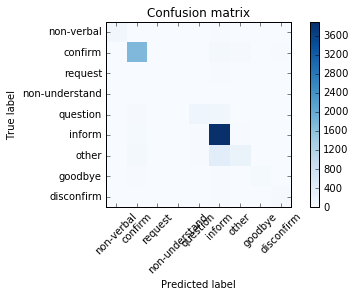

In [9]:
print np.mean(predicted == y_test)
print metrics.classification_report(y_test, predicted, target_names=tag_list)
plot_confusion_matrix(metrics.confusion_matrix(y_test, predicted))